In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
import numpy as np
from pathlib import Path
import nibabel as nib
import cv2 
from functools import lru_cache

/Users/alexanderdann/Documents/Privat/Code/Repositories/computer-vision-projects/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cache_dir = Path("/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K")

In [4]:
files = [file.parent for file in cache_dir.rglob("*") if file.suffix == ".gz"]
files

[PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0001_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0001_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0005_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0005_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0004_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0004_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0003_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0003_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0002_CT/1/NIFTI'),
 PosixPath('/Users/alexanderdann/Documents/Privat/Code/Data/CTSpine1K/0002_CT/1/NIFTI')]

In [5]:
def load_slice(file_path: Path, slice_idx: int, axis: int = 2) -> np.ndarray:
    img = nib.load(file_path)  # this only loads the header
    shape = img.shape

    print(shape)

    if slice_idx < 0 or slice_idx >= shape[axis]:
        msg = f"Slice index {slice_idx} out of bounds (0-{shape[axis] - 1})"
        raise ValueError(msg)

    # Create slicer to extract only the slice we want
    slicer = [slice(None)] * len(shape)
    slicer[axis] = slice(slice_idx, slice_idx + 1)

    data_slice = img.dataobj[tuple(slicer)]
    data_slice = np.squeeze(data_slice)

    return data_slice


slice_ = load_slice(file_path=files[0] / "image.nii.gz", slice_idx=420)
annot_ = load_slice(file_path=files[1] / "image.nii.gz", slice_idx=420)

(512, 512, 604)
(512, 512, 604)


In [6]:
class CTSpine1K:
    """Dataloading iterator for the CTSpine1K dataset."""

    def __init__(
        self,
        cache_dir: Path,
        *,
        volumetric: bool = False,
    ) -> None:
        self._volumetric: bool = volumetric

        self._lookup = self._validate_check(cache_dir=cache_dir)

        print(f"Found {len(self)} samples.")

    @property
    def volumetric(self) -> bool:
        """Mode indicating whether we use 3D or 2D data."""
        return self._volumetric

    def __len__(self) -> int:
        """Length attribute of the class.

        Returns:
            Return the amount of samples based on mode.

        """
        if self.volumetric:
            return len(self._lookup)

        return sum(self._lookup.values())

    def _validate_check(self, cache_dir: Path) -> dict:
        candidates = {
            file.parent
            for file in cache_dir.rglob("*")
            if "nii.gz" in file.as_uri().lower()
        }
        samples = {}

        for candidate in candidates:
            file_path = candidate / "image.nii.gz"
            segmentation_path = candidate / "segmentation.nii.gz"

            if (file_path).is_file() and (segmentation_path).is_file():
                image_slices = self._get_sample_length(file_path)
                segmentation_slices = self._get_sample_length(segmentation_path)
                if image_slices != segmentation_slices:
                    msg = (
                        f"Image slices ({len(image_slices)}) are not equal to "
                        "segmentation slices ({len(segmentation_slices)})"
                    )
                    raise ValueError(msg)

                samples[candidate] = image_slices

        return samples

    @lru_cache(maxsize=1)  # since it does not change  # noqa: B019
    def _sorted_lookup(self) -> list[Path]:
        return sorted(self._lookup.keys())

    @staticmethod
    def _get_sample_length(file_path: Path) -> int:
        expected_ndim = 3
        img = nib.load(file_path)  # this only loads the header
        shape = img.shape
        assert len(shape) == expected_ndim
        return shape[2]

    @staticmethod
    def _sliced_sample(path: Path, slice_idx: int, axis: int = 2) -> np.ndarray:
        img = nib.load(path)  # this only loads the header
        shape = img.shape

        if slice_idx < 0 or slice_idx >= shape[axis]:
            msg = f"Slice index {slice_idx} out of bounds (0-{shape[axis] - 1})"
            raise ValueError(msg)

        # Create slicer to extract only the slice we want
        slicer = [slice(None)] * len(shape)
        slicer[axis] = slice(slice_idx, slice_idx + 1)

        data_slice = img.dataobj[tuple(slicer)]
        return np.squeeze(data_slice).copy()

    @staticmethod
    def _volumetric_sample(path: Path) -> None:
        msg = "Volumetric processing currently not supported"
        raise NotImplementedError(msg)

    def _resolve_index(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        if self._volumetric:
            path: Path = self._sorted_lookup[index]
            return (
                self._volumetric_sample(path / "image.nii.gz"),
                self._volumetric_sample(path / "segmentation.nii.gz"),
            )

        lower: int = 0

        for path, value in self._lookup.items():
            upper = lower + value

            if lower <= index < upper:
                return (
                    self._sliced_sample(path / "image.nii.gz", index - lower),
                    self._sliced_sample(path / "segmentation.nii.gz", index - lower),
                )

            lower = upper

        print(self._sorted_lookup())
        msg = f"Trying access out of bound entry for dataset with {len(self)}."
        raise ValueError(msg)

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        """Fetch a single item given the index.

        Args:
            index: number representing the given entry.

        Returns:
            A single training sample as a tuple of input and output for training.

        """
        input_image, annotation = self._resolve_index(index)

        input_image = cv2.normalize(input_image, None, 0, 255, cv2.NORM_MINMAX) / 255
        annotation[annotation != 0] = 1

        return input_image, annotation


In [ ]:
class PromptSampler:
    def __init__(self,) -> None:
        pass

In [28]:
import numpy as np
import cv2
from scipy.ndimage import distance_transform_edt


def create_gaussian_ramp(mask, sigma=10.0):
    """
    Creates a Gaussian ramp from the boundary of a binary mask.

    Args:
        mask: Binary mask (0 and 1)
        sigma: Controls width of the Gaussian transition

    Returns:
        A float image with values transitioning from 1 at the center to 0 at the boundary
    """
    # Distance transform - each pixel gets its distance to nearest boundary
    dist = distance_transform_edt(mask)

    # Create Gaussian decay from the boundary
    # Values will be 0 at boundary, increasing toward center
    ramp = 1 - np.exp(-(dist**2) / (2 * sigma**2))

    return ramp

In [7]:
dataset = CTSpine1K(cache_dir=cache_dir)

Found 2825 samples.


In [116]:
inputs, mask = dataset[1110]

In [117]:
ramp_mask = create_gaussian_ramp(mask, sigma=0.5)
ramp_mask[ramp_mask == mask] = 0
ramp_mask[ramp_mask <= 0.99] = 0
np.unique(1-ramp_mask)

array([2.22044605e-16, 1.66533454e-15, 1.26565425e-14, 5.10913534e-12,
       2.06115358e-09, 1.52299797e-08, 1.12535175e-07, 4.53999298e-05,
       3.35462628e-04, 1.00000000e+00])

In [118]:
alpha = 0.2

dist = distance_transform_edt(mask)
prob = dist / np.amax(dist)
prob /= alpha


prob[prob>1] = 1 
prob[prob == mask] = 0


In [113]:
np.unique(prob)

array([0.        , 0.24282147, 0.34340141, 0.48564293, 0.5429653 ,
       0.68680282, 0.7284644 , 0.7678689 , 0.87550524, 0.97128586])

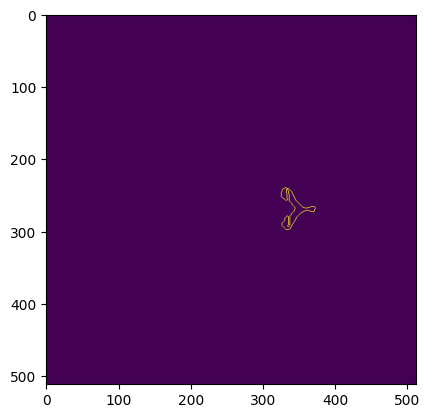

In [119]:
import matplotlib.pyplot as plt


plt.imshow(prob)

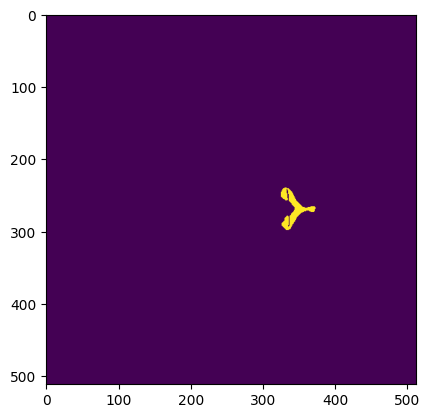

In [120]:
plt.imshow(mask)


In [54]:
import plotly.graph_objects as go
import numpy as np
from PIL import Image

# Sample points with visibility toggle state
points = [
    {"name": "Point 1", "x": 150, "y": 150, "color": "red", "visible": True},
    {"name": "Point 2", "x": 250, "y": 250, "color": "blue", "visible": True},
    {"name": "Point 3", "x": 350, "y": 150, "color": "green", "visible": False},
]

import plotly.graph_objects as go
import numpy as np
import base64
from io import BytesIO
from PIL import Image


def plot_points_on_image(img_array, points):
    # Get image dimensions
    if len(img_array.shape) == 3:
        img_height, img_width, _ = img_array.shape
    else:
        img_height, img_width = img_array.shape
    
    # Convert numpy array to base64 for Plotly
    img = Image.fromarray(img_array.astype(np.uint8))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_base64 = f"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
    # Create figure
    fig = go.Figure()

    # Add image
    fig.add_layout_image(
        {
            "source": img_base64,
            "x": 0,
            "y": 0,
            "xref": "x",
            "yref": "y",
            "sizex": img_width,
            "sizey": img_height,
            "sizing": "stretch",
            "layer": "below",
        }
    )

    # Filter visible points
    visible_points = [p for p in points if p["visible"]]

    # Add points
    if visible_points:
        fig.add_trace(
            go.Scatter(
                x=[p["x"] for p in visible_points],
                y=[p["y"] for p in visible_points],
                mode="markers",
                marker=dict(color=[p["color"] for p in visible_points], size=10),
                text=[p["name"] for p in visible_points],
                hoverinfo="text",
            )
        )

    # Set layout
    fig.update_layout(
        width=img_width,
        height=img_height,
        xaxis=dict(range=[0, img_width], visible=False),
        yaxis=dict(
            range=[img_height, 0],  # Inverted for image coordinates
            visible=False,
            scaleanchor="x",
            scaleratio=1,
        ),
        margin=dict(l=0, r=0, t=0, b=0),
    )

    return fig

In [125]:
plot_points_on_image((inputs[:, :, None] + prob[:, :, None]*(1.0, 0.0, 0.0))*255, points)

# SAM2

In [13]:
import os

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import torch
from PIL import Image

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")

print(f"using device: {device}")


using device: cpu


In [14]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [15]:
image = np.concatenate([inputs[:, :, None] for _ in range(3)], axis=-1).astype(np.float32)

In [16]:
predictor.set_image(image)

In [17]:
import matplotlib.pyplot as plt
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [23]:
input_point = np.array([[240, 125]])
input_label = np.array([1])

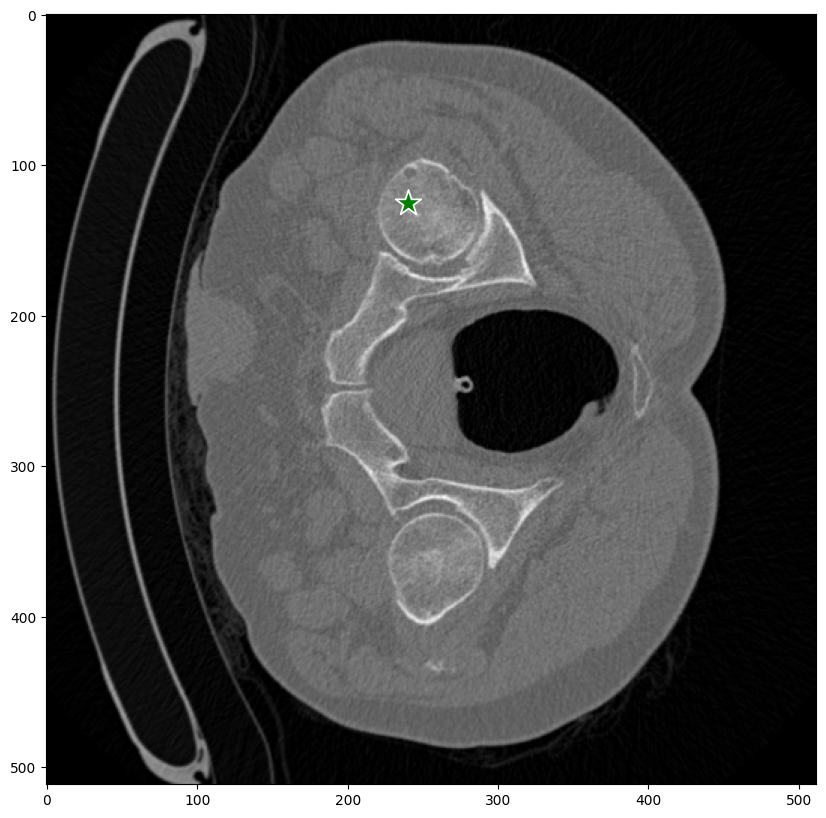

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [25]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

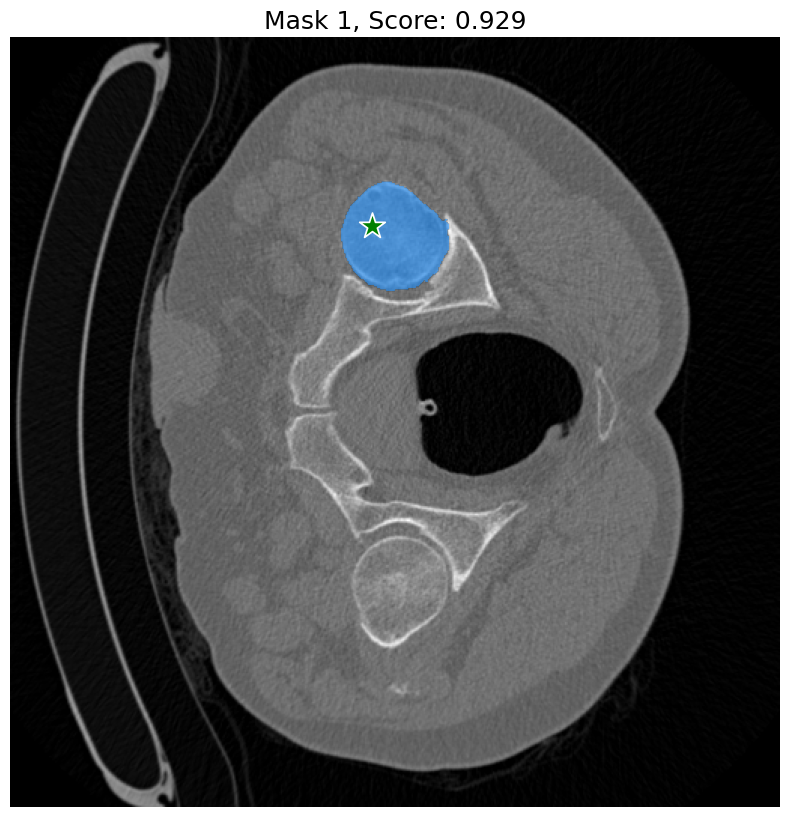

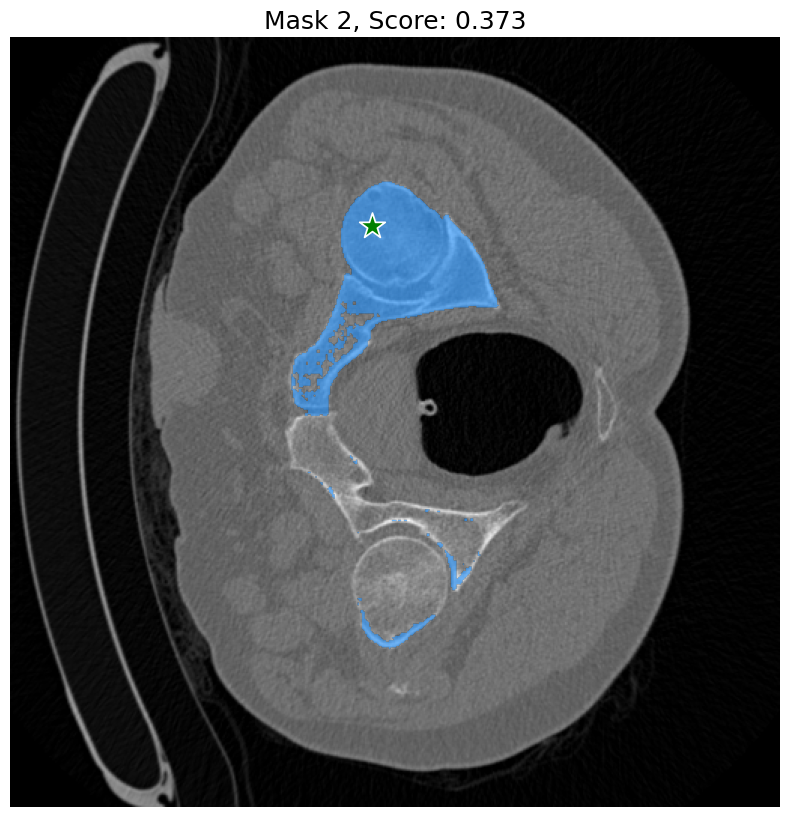

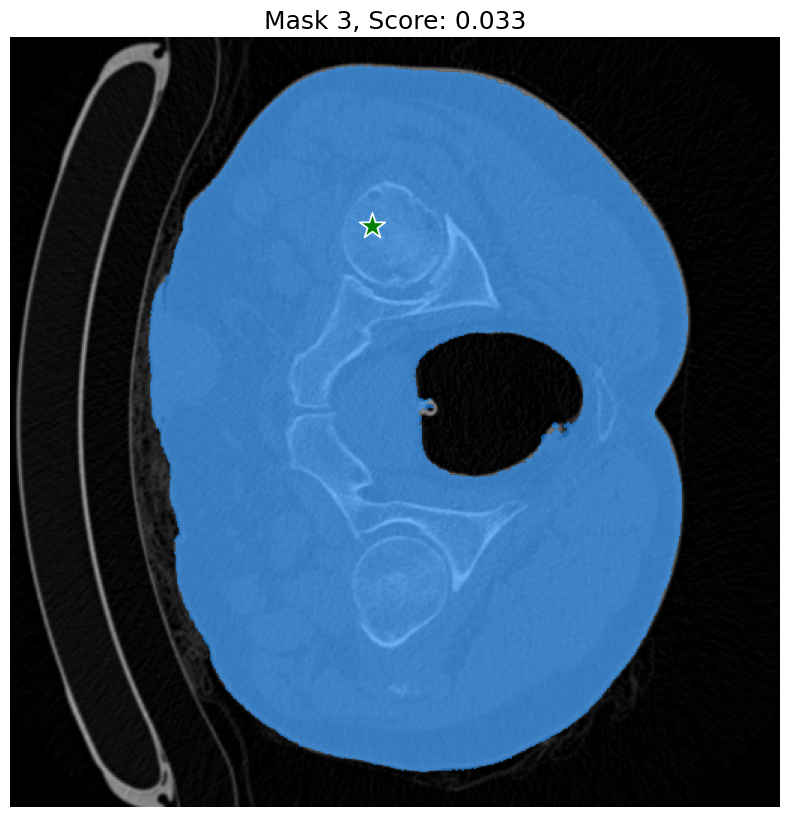

In [27]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=False)